/tmp/ipykernel_554226/1200649436.py:102: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig,


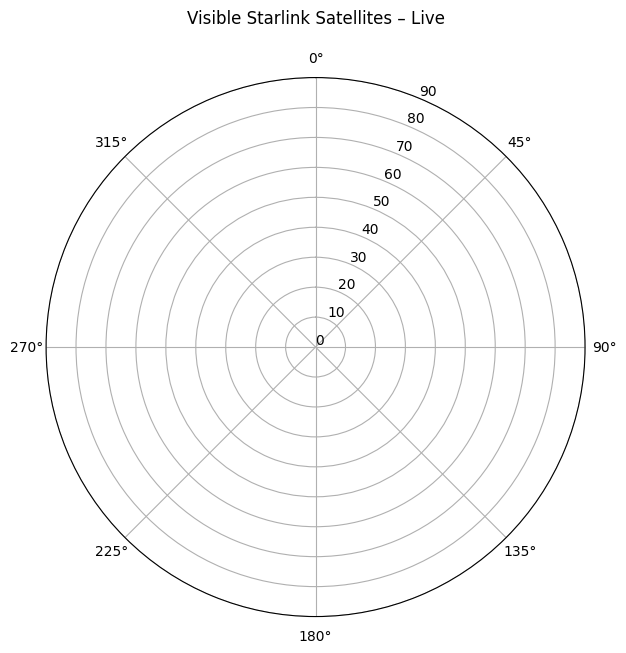

In [ ]:
import numpy as np
import pandas as pd
import requests, datetime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from skyfield.api import load, EarthSatellite, wgs84

# ───────────────────────────────────────────────────────────────
# CONFIG
# ----------------------------------------------------------------
OBSERVER = dict(lat=40.0822, lon=-105.1092, elev=1_560)   # Boulder, CO
ELEV_MIN_DEG   = 10                                       # min elevation
MAX_SAT_NUMBER = 800                                      # cap for speed
REFRESH_SEC    = 5                                        # animation period

DOT_STYLE = dict(marker='o', s=35,
                 edgecolor='k', linewidth=0.3, alpha=0.9,
                 color='tab:blue')

# ───────────────────────────────────────────────────────────────
# 1) Robust Starlink TLE loader
# ----------------------------------------------------------------
def load_starlink(max_n=MAX_SAT_NUMBER):
    url = ("https://celestrak.com/NORAD/elements/gp.php"
           "?GROUP=starlink&FORMAT=tle")
    text = requests.get(url, timeout=10).text.strip().splitlines()

    ts   = load.timescale()
    sats = []
    for i in range(0, len(text) - 2, 3):        # 只拿完整的 3 行组
        try:
            sats.append(EarthSatellite(text[i+1], text[i+2],
                                       text[i].strip(), ts))
        except ValueError:                      # 行格式坏掉就跳过
            continue
        if len(sats) >= max_n:
            break
    return sats, ts

SAT_LIST, TS = load_starlink()

# ───────────────────────────────────────────────────────────────
# 2) Helper: visible satellites → DataFrame
# ----------------------------------------------------------------
OBSERV_TOPOS = wgs84.latlon(OBSERVER['lat'],
                            OBSERVER['lon'],
                            OBSERVER['elev'])

def visible_starlinks(ts, sats, elev_min=ELEV_MIN_DEG):
    t_now = ts.now()
    rows  = []
    for sat in sats:
        alt, az, _ = (sat - OBSERV_TOPOS).at(t_now).altaz()
        if alt.degrees >= elev_min:
            rows.append([sat.name, az.degrees, alt.degrees])
    return pd.DataFrame(rows, columns=['Name', 'Azimuth', 'Elevation'])

# ───────────────────────────────────────────────────────────────
# 3) Build polar plot
# ----------------------------------------------------------------
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='polar')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_rticks(range(0, 91, 10))
ax.set_title("Visible Starlink Satellites – Live", pad=20)

scat   = ax.scatter([], [], **DOT_STYLE)
empty_xy = np.empty((0, 2))
annot  = ax.text(0.5, -0.08, '', ha='center', va='top',
                 transform=ax.transAxes, fontsize=9)

# ───────────────────────────────────────────────────────────────
# 4) Animation
# ----------------------------------------------------------------
def init():
    scat.set_offsets(empty_xy)
    annot.set_text('')
    return scat, annot

def update(_):
    df = visible_starlinks(TS, SAT_LIST)
    if df.empty:
        scat.set_offsets(empty_xy)
        annot.set_text(f"No sats ≥ {ELEV_MIN_DEG}°  "
                       f"{datetime.datetime.now():%H:%M:%S}")
        return scat, annot

    theta = np.radians(df['Azimuth'].values)
    r     = df['Elevation'].values
    scat.set_offsets(np.c_[theta, r])

    annot.set_text(f"{len(df)} sats   "
                   f"{datetime.datetime.now():%H:%M:%S}")
    return scat, annot

ani = FuncAnimation(fig,
                    update,
                    init_func=init,
                    interval=REFRESH_SEC*1000,
                    blit=False)        

plt.show()


/tmp/ipykernel_114024/1176215922.py:61: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


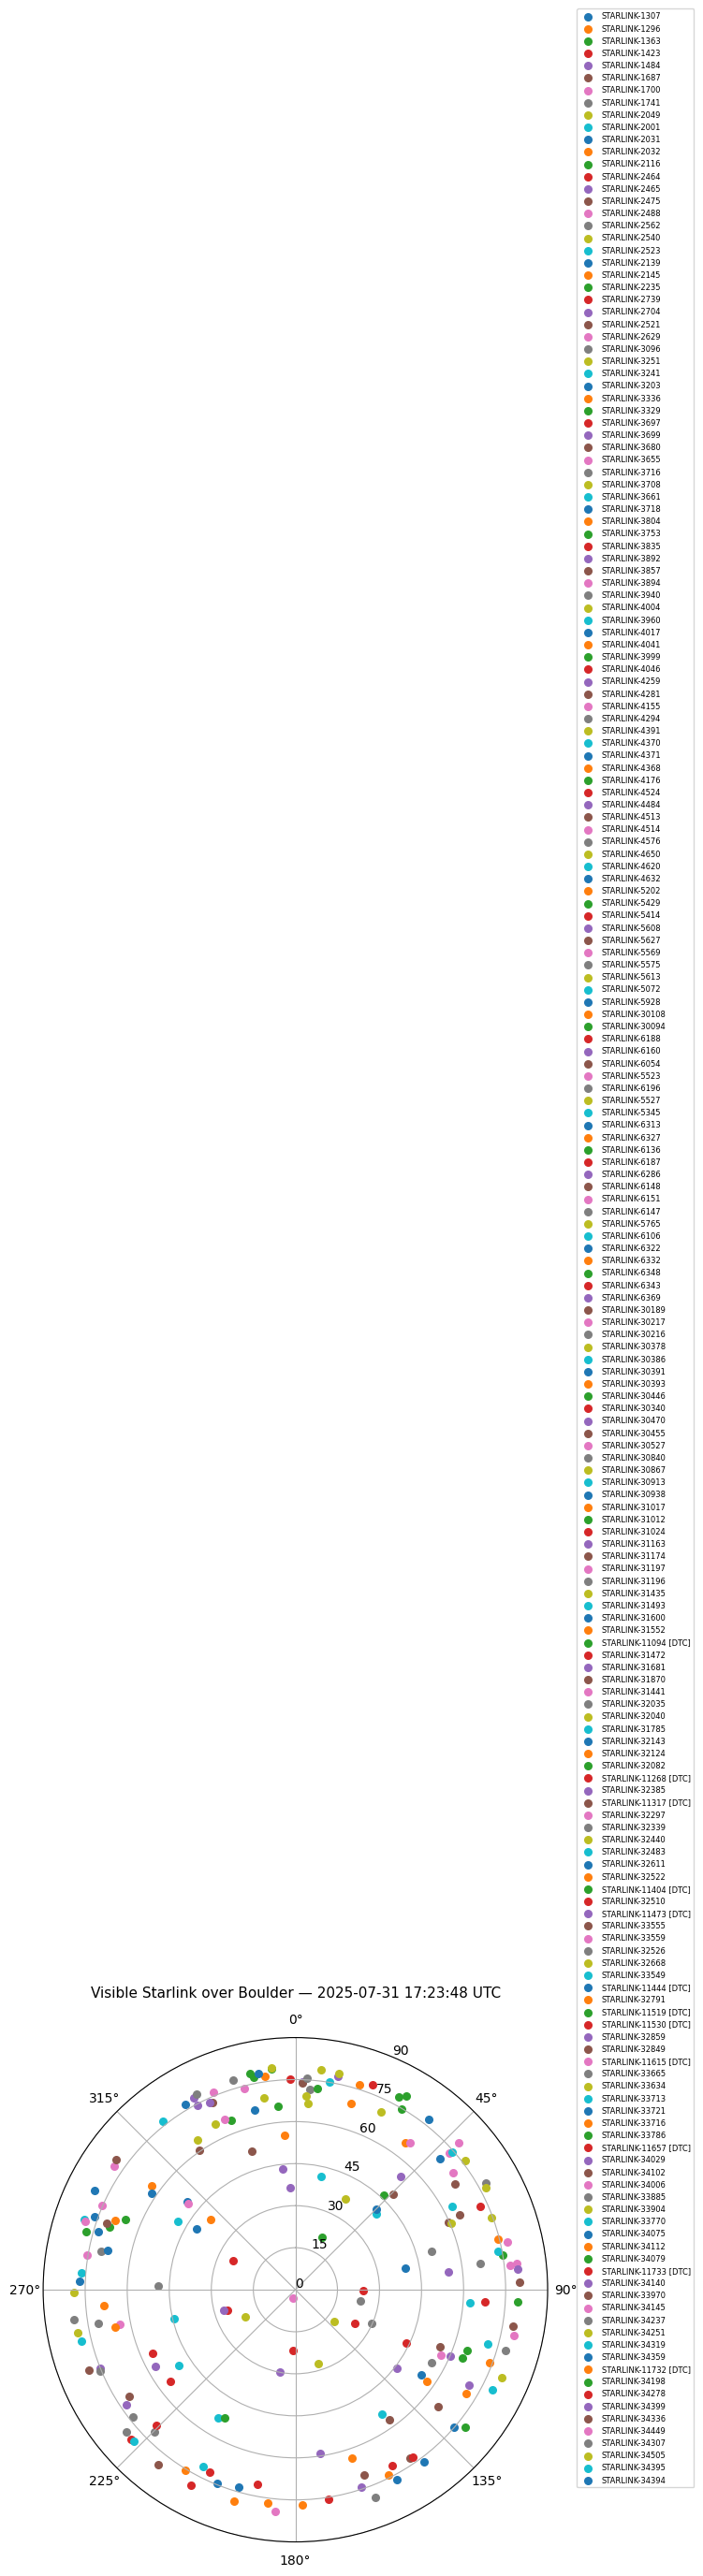

In [2]:
import requests, datetime
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load, EarthSatellite, Topos

# --------------------------------------------------------------
# Observer (Boulder, CO)
lat, lon, elev = 40.0822, -105.1092, 1560     # °, °, m
observer = Topos(latitude_degrees=lat,
                 longitude_degrees=lon,
                 elevation_m=elev)

# --------------------------------------------------------------
# Grab Starlink TLEs (robust)
url = ("https://celestrak.com/NORAD/elements/gp.php"
       "?GROUP=starlink&FORMAT=tle")

resp = requests.get(url, timeout=10)
lines = [ln.strip() for ln in resp.text.splitlines() if ln.strip()]

ts   = load.timescale()
sats = []
for i in range(0, len(lines) - 2, 3):          # only full 3-line blocks
    name, l1, l2 = lines[i], lines[i+1], lines[i+2]
    # skip corrupt groups that don't start with "1 " / "2 "
    if not (l1.startswith('1 ') and l2.startswith('2 ')):
        continue
    try:
        sats.append((name, EarthSatellite(l1, l2, name, ts)))
    except ValueError:
        pass    # bad checksum → skip

# --------------------------------------------------------------
# Find visible satellites
t_now = ts.now()
visible = []
for name, sat in sats:
    alt, az, _ = (sat - observer).at(t_now).altaz()
    if alt.degrees > 10:
        visible.append((name, az.degrees, alt.degrees))

# --------------------------------------------------------------
# Polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7, 7))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0, 90)
ax.set_rticks(range(0, 91, 15))
ax.set_title(f"Visible Starlink over Boulder — {t_now.utc_datetime():%Y-%m-%d %H:%M:%S} UTC",
             fontsize=11, pad=12)

for name, az_deg, alt_deg in visible:
    ax.scatter(np.radians(az_deg), 90 - alt_deg, s=30, label=name)

if visible:
    ax.legend(fontsize=6, loc='lower left', bbox_to_anchor=(1.05, 0.1))
else:
    ax.text(0.5, 0.5, "No satellites\nabove 10°", ha='center', va='center',
            transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


In [3]:
"""
Compute Starlink satellites that satisfy user-defined
elevation / azimuth / range constraints and express their
locations in a local ENU Cartesian frame whose origin is the
ground station (x = East, y = North, z = Up).
"""

import numpy as np
import pandas as pd
import requests
from skyfield.api import load, EarthSatellite, wgs84
from skyfield.framelib import itrs  # Earth-fixed ITRF frame
ts = load.timescale()


# ───────────────────────────────────────────────────────────────
# 3) Download Starlink TLEs and append satellites
# ----------------------------------------------------------------
url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle"
HEADERS = {"User-Agent": "sat-tracker/1.0 (+https://github.com/you/repo)"}
tle_lines = requests.get(url, timeout=10).text.strip().splitlines()

sats = []
for i in range(0, len(tle_lines) - 2, 3):  # Process full TLE blocks
    name = tle_lines[i].strip()
    l1 = tle_lines[i+1].strip()
    l2 = tle_lines[i+2].strip()
    if not (l1.startswith("1 ") and l2.startswith("2 ")):
        continue
    try:
        sats.append((name, EarthSatellite(l1, l2, name, ts)))
    except ValueError:
        continue
    
    


In [16]:
# ───────────────────────────────────────────────────────────────
# 0) User-configurable parameters
# ----------------------------------------------------------------
ELEV_MIN_DEG   = 10           # Minimum elevation (deg)
AZ_RANGE_DEG   = (0, 360)     # Azimuth range [start, end)
MAX_SLANT_KM   = 9999         # Maximum slant range (km)

# ───────────────────────────────────────────────────────────────
# 1) Observer definition (Boulder, CO)
# ----------------------------------------------------------------
lat, lon, elev = 40.0822, -105.1092, 1560  # meters
ts = load.timescale()
t = ts.now()
topos = wgs84.latlon(lat, lon, elev)

# Build ECEF → ENU rotation matrix
phi = np.radians(lat)
lam = np.radians(lon)
R_ecef2enu = np.array([
    [-np.sin(lam),              np.cos(lam),               0.0],
    [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
    [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
])

# ───────────────────────────────────────────────────────────────
# 2) Initialize empty list to hold satellite rows
# ----------------------------------------------------------------
rows = []




# ───────────────────────────────────────────────────────────────
# 4) Evaluate satellites
# ----------------------------------------------------------------
for name, sat in sats:
    alt, az, dist = (sat - topos).at(t).altaz()
    slant_km = dist.km

    if alt.degrees < ELEV_MIN_DEG:
        continue
    if not (AZ_RANGE_DEG[0] <= az.degrees < AZ_RANGE_DEG[1]):
        continue
    if slant_km > MAX_SLANT_KM:
        continue

    sat_ecef = sat.at(t).frame_xyz(itrs).m
    obs_ecef = topos.at(t).frame_xyz(itrs).m
    enu = R_ecef2enu @ (sat_ecef - obs_ecef)

    rows.append([
        name,
        round(az.degrees, 2),
        round(alt.degrees, 2),
        round(slant_km, 1),
        *np.round(enu, 1)
    ])

# ───────────────────────────────────────────────────────────────
# 5) Output results
# ----------------------------------------------------------------
columns = ["Name", "Azimuth (°)", "Elevation (°)", "Slant km",
           "x_East (m)", "y_North (m)", "z_Up (m)"]
df = pd.DataFrame(rows, columns=columns)

# Optional: sort by slant distance
df = df.sort_values(by="Slant km", ascending=True).reset_index(drop=True)

print(df.to_string(index=False))


                Name  Azimuth (°)  Elevation (°)  Slant km  x_East (m)  y_North (m)  z_Up (m)
      STARLINK-30617        58.08          67.17     514.3    169346.9     105482.9  473997.5
      STARLINK-31475       100.88          60.99     549.0    261454.9     -50262.9  480095.2
       STARLINK-5672        62.62          86.26     562.0     32570.7      16869.7  560798.0
      STARLINK-32688        37.95          58.22     563.5    182492.4     234008.2  479074.9
STARLINK-11665 [DTC]        69.42          35.72     582.6    442818.3     166276.8  340182.1
      STARLINK-30480        11.28          54.86     583.6     65691.2     329415.1  477255.5
      STARLINK-32332       171.23          54.05     587.2     52549.6    -340743.2  475373.6
      STARLINK-30559       103.60          60.12     588.0    284773.0     -68877.0  509824.2
STARLINK-11428 [DTC]       319.09          35.39     590.1   -315020.5     363545.0  341755.8
      STARLINK-32592       321.56          53.56     592.1  

In [19]:
from datetime import datetime, timedelta
from skyfield.api import utc
import numpy as np
import pandas as pd

# ───────────────────────────────────────────────────────────────
# Observer definition (Boulder, CO)
# ----------------------------------------------------------------
lat, lon, elev = 40.0822, -105.1092, 1560  # meters
topos = wgs84.latlon(lat, lon, elev)

# Build ECEF → ENU rotation matrix
phi = np.radians(lat)
lam = np.radians(lon)
R_ecef2enu = np.array([
    [-np.sin(lam),              np.cos(lam),               0.0],
    [-np.sin(phi)*np.cos(lam), -np.sin(phi)*np.sin(lam),  np.cos(phi)],
    [ np.cos(phi)*np.cos(lam),  np.cos(phi)*np.sin(lam),  np.sin(phi)]
])

# ───────────────────────────────────────────────────────────────
# Sampling every 5 seconds for 15 minutes
# ----------------------------------------------------------------
ELEV_MIN_DEG = 30
AZ_RANGE_DEG = (0, 360)
MAX_SLANT_KM = 9999
DURATION_SEC = 15 * 60         # 15 minutes
INTERVAL_SEC = 3               # 5-second interval

rows = []
start_time = datetime.utcnow().replace(tzinfo=utc)

for i in range(0, DURATION_SEC, INTERVAL_SEC):
    current_dt = start_time + timedelta(seconds=i)
    t = ts.utc(current_dt)

    for name, sat in sats:
        alt, az, dist = (sat - topos).at(t).altaz()
        if alt.degrees < ELEV_MIN_DEG:
            continue
        if not (AZ_RANGE_DEG[0] <= az.degrees < AZ_RANGE_DEG[1]):
            continue
        if dist.km > MAX_SLANT_KM:
            continue

        sat_ecef = sat.at(t).frame_xyz(itrs).m
        obs_ecef = topos.at(t).frame_xyz(itrs).m
        enu = R_ecef2enu @ (sat_ecef - obs_ecef)

        rows.append([
            current_dt.strftime("%Y-%m-%d %H:%M:%S"),
            name,
            round(az.degrees, 2),
            round(alt.degrees, 2),
            round(dist.km, 1),
            *np.round(enu, 1)
        ])

# ───────────────────────────────────────────────────────────────
# Save to CSV
# ----------------------------------------------------------------
columns = ["Time", "Name", "Azimuth (°)", "Elevation (°)", "Slant km",
           "x_East (m)", "y_North (m)", "z_Up (m)"]
df = pd.DataFrame(rows, columns=columns)

df = df.sort_values(by=["Time", "Slant km"]).reset_index(drop=True)
df.to_csv("starlink_visibility_15min_5s_interval.csv", index=False)


/tmp/ipykernel_134484/1560315266.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab20")


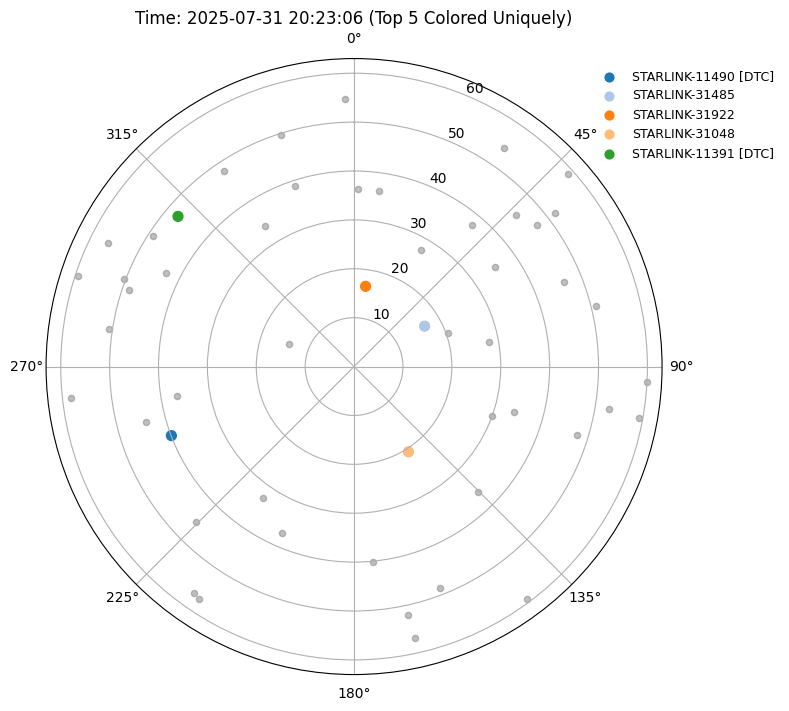

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
from matplotlib import cm

# Load CSV
df = pd.read_csv("starlink_visibility_15min_5s_interval.csv")
grouped = df.groupby("Time")
time_points = list(grouped.groups.keys())


# Color generator from tab20 (20 unique colors, looped if exhausted)
colormap = cm.get_cmap("tab20")
color_palette = itertools.cycle([colormap(i) for i in range(20)])

global_color_map = {}  # name → color

# Setup figure
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(0, 90 - ELEV_MIN_DEG + 3)

scat_top5 = ax.scatter([], [], s=50)
scat_others = ax.scatter([], [], s=20, c='gray', alpha=0.5)
title_text = ax.set_title("", fontsize=12)

# Initialize legend handles
legend_handles = []

def update(frame):
    global legend_handles
    time = time_points[frame]
    data = grouped.get_group(time).sort_values(by="Slant km")

    top5 = data.head(5)
    others = data.iloc[5:]

    # Assign new color if satellite never seen before
    for name in top5["Name"]:
        if name not in global_color_map:
            global_color_map[name] = next(color_palette)

    # Extract coordinates
    theta_top5 = np.radians(top5["Azimuth (°)"])
    radius_top5 = 90 - top5["Elevation (°)"]
    colors_top5 = [global_color_map[name] for name in top5["Name"]]

    theta_others = np.radians(others["Azimuth (°)"])
    radius_others = 90 - others["Elevation (°)"]

    # Update scatter plot
    scat_top5.set_offsets(np.c_[theta_top5, radius_top5])
    scat_top5.set_color(colors_top5)

    scat_others.set_offsets(np.c_[theta_others, radius_others])
    title_text.set_text(f"Time: {time} (Top 5 Colored Uniquely)")

    # Update legend
    for h in legend_handles:
        h.remove()
    legend_handles = []

    for name in top5["Name"]:
        color = global_color_map[name]
        h = ax.scatter([], [], c=[color], label=name, s=40)
        legend_handles.append(h)

    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9, frameon=False)

    return scat_top5, scat_others, title_text, *legend_handles

ani = FuncAnimation(fig, update, frames=len(time_points), interval=200, blit=False)
ani.save("starlink_unique_color.gif", dpi=120, writer="pillow")

# Or save as mp4
# ani.save("starlink_unique_color.mp4", dpi=120, writer="ffmpeg")
